# Objetivo
Prever a demanda semanal dos 5 produtos mais vendidos em um e-commerce para a cidade de São Paulo, com base no histórico de vendas diárias. O projeto abrange:

* **Preparação dos dados:** Limpeza, transformação e engenharia de features.
* **Modelagem:** Desenvolvimento e treinamento de modelos de previsão.
* **Avaliação:** Análise de desempenho e validação dos resultados.

O objetivo final é gerar previsões precisas para auxiliar no planejamento de estoque e logística.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from workalendar.america import Brazil
from datetime import datetime, timedelta

from catboost import CatBoostRegressor

# Extração e entendimento dos dados

**Fonte de Dados:**

* [orders_dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_orders_dataset.csv): Este é o conjunto de dados principal. De cada pedido, você poderá encontrar todas as outras informações.
* [orders_itens_dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_order_items_dataset.csv): Este conjunto de dados inclui dados sobre os itens comprados em cada pedido.
* [products_dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_products_dataset.csv): Este conjunto de dados inclui dados sobre os produtos vendidos pela Olist.
* [customers_dataset](https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce?select=olist_customers_dataset.csv): Este conjunto de dados contém informações sobre o cliente e sua localização. Use-o para identificar clientes únicos no conjunto de dados de pedidos e encontrar o local de entrega dos pedidos.

Em decorrência desse conjunto de tabelas, os principais passos iniciais são:

1. **Verificação de Qualidade**  
   - Checar valores nulos, outliers e inconsistências em cada tabela antes da junção.  
   - Validar integridade após a agregação (ex.: pedidos sem itens, produtos sem vendas).


2. **Integração de Dados** 
   - Unir tabelas de pedidos, itens, produtos e clientes usando chaves comuns (`order_id`, `product_id`, `customer_id`).
   - Garantir que padrões e distribuições originais foram mantidos após a junção.  
   - Documentar quaisquer tratamentos aplicados.

In [2]:
def load_and_inspect(filepath, name):
    """Carrega dataset e exibe informações básicas"""
    print(f"Análise do Dataset: {name.upper()} --------------------------------------- \n")
    
    df = pd.read_csv(filepath)
    print(f"Dimensões: {df.shape}")
    
    null_counts = df.isnull().sum()
    if null_counts.sum() == 0:
        print("✅ Nenhum valor nulo encontrado \n")
    else:
        print("\nValores ausentes:")
        display(null_counts[null_counts > 0].to_frame(name='Qtd. Nulos'))
    
    return df

orders_df = load_and_inspect("dados/olist_orders_dataset.csv", "Pedidos")
order_items_df = load_and_inspect("dados/olist_order_items_dataset.csv", "Itens de Pedido")
products_df = load_and_inspect("dados/olist_products_dataset.csv", "Produtos")
customers_df = load_and_inspect("dados/olist_customers_dataset.csv", "Clientes")

order_items_df = (order_items_df
                 .groupby(["order_id", "product_id"])
                 .agg(quantidade=("price", "count"),
                      valor_total=("price", "sum"),
                      frete_total=("freight_value", "sum"))
                 .reset_index())

print(f"Dimensões após transformação: {order_items_df.shape}")
display(order_items_df.head(3))

Análise do Dataset: PEDIDOS --------------------------------------- 

Dimensões: (99441, 8)

Valores ausentes:


,Qtd. Nulos
order_approved_at,160
order_delivered_carrier_date,1783
order_delivered_customer_date,2965


Análise do Dataset: ITENS DE PEDIDO --------------------------------------- 

Dimensões: (112650, 7)
✅ Nenhum valor nulo encontrado 

Análise do Dataset: PRODUTOS --------------------------------------- 

Dimensões: (32951, 9)

Valores ausentes:


,Qtd. Nulos
product_category_name,610
product_name_lenght,610
product_description_lenght,610
product_photos_qty,610
product_weight_g,2
product_length_cm,2
product_height_cm,2
product_width_cm,2


Análise do Dataset: CLIENTES --------------------------------------- 

Dimensões: (99441, 5)
✅ Nenhum valor nulo encontrado 

Dimensões após transformação: (102425, 5)


,order_id,product_id,quantidade,valor_total,frete_total
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,58.9,13.29
1,00018f77f2f0320c557190d7a144bdd3,e5f2d52b802189ee658865ca93d83a8f,1,239.9,19.93
2,000229ec398224ef6ca0657da4fc703e,c777355d18b72b67abbeef9df44fd0fd,1,199.0,17.87


In [3]:
joined_df = (
    orders_df
    .merge(order_items_df, how="left", on=["order_id"])
    .merge(products_df, how="left", on=["product_id"])
    .merge(customers_df, how="left", on=["customer_id"])
)

joined_df['order_purchase_timestamp'] = pd.to_datetime(joined_df['order_purchase_timestamp'])
joined_df['order_purchase_date'] = [pd.to_datetime(day) - pd.Timedelta(days=day.weekday()) for day in joined_df['order_purchase_timestamp'].dt.normalize()] 
joined_df['order_purchase_original_date'] = pd.to_datetime(joined_df['order_purchase_timestamp']).dt.normalize()
joined_df['order_purchase_month'] = pd.to_datetime(pd.to_datetime(joined_df['order_purchase_timestamp']).dt.strftime('%Y-%m-01'))

print(f"Dimensões: {joined_df.shape}")
null_counts = joined_df.isnull().sum()
if null_counts.sum() == 0:
    print("✅ Nenhum valor nulo encontrado \n")
else:
    print("\nValores ausentes:")
    display(null_counts[null_counts > 0].to_frame(name='Qtd. Nulos'))

Dimensões: (103200, 27)

Valores ausentes:


,Qtd. Nulos
order_approved_at,160
order_delivered_carrier_date,1802
order_delivered_customer_date,3005
product_id,775
quantidade,775
valor_total,775
frete_total,775
product_category_name,2235
product_name_lenght,2235
product_description_lenght,2235


As datas fora do intervalo principal (antes de 2017 e após agosto/2018) apresentam poucos registros, mesmo quando agrupadas por semana, indicando que devem ser excluídas da análise.  

**Destaques principais**:  
- **Cidades mais frequentes**: São Paulo, Rio de Janeiro e Belo Horizonte lideram em volume de pedidos.  
- **Produtos mais vendidos**: Eletrônicos, móveis e artigos esportivos são as categorias predominantes.  

Esses filtros e tabelas mostram quais produtos devem ser utilizados na modelagem.


----------------------------------------------------------------------------------------------------
ANÁLISE DA COLUNA: ORDER_PURCHASE_DATE
----------------------------------------------------------------------------------------------------


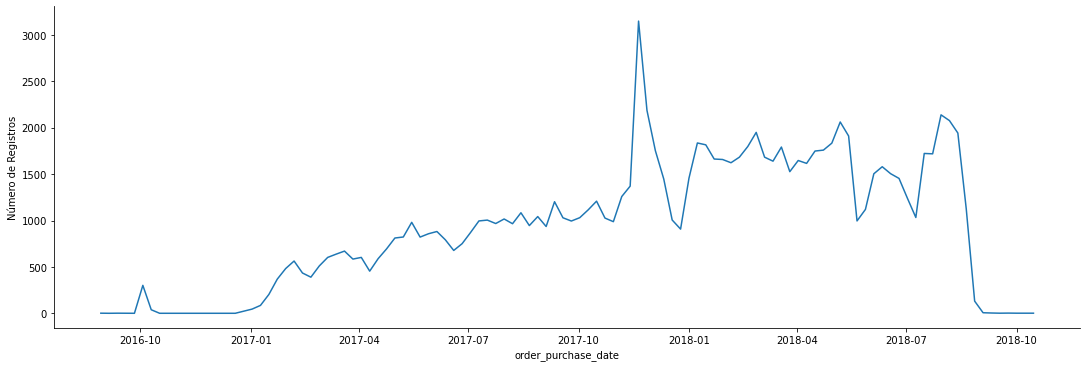


----------------------------------------------------------------------------------------------------
ANÁLISE DA COLUNA: ORDER_STATUS
----------------------------------------------------------------------------------------------------
Quantidade de categorias únicas: 8

Top 10 categorias (de 8):


,Categoria,Proporção,Contagem
0,delivered,97.09%,100196
1,shipped,1.09%,1128
2,canceled,0.61%,629
3,unavailable,0.59%,610
4,invoiced,0.31%,324
5,processing,0.30%,306
6,created,0.00%,5
7,approved,0.00%,2



----------------------------------------------------------------------------------------------------
ANÁLISE DA COLUNA: PRODUCT_CATEGORY_NAME
----------------------------------------------------------------------------------------------------
Quantidade de categorias únicas: 73

Top 10 categorias (de 73):


,Categoria,Proporção,Contagem
0,cama_mesa_banho,10.06%,10160
1,beleza_saude,8.94%,9022
2,esporte_lazer,7.78%,7858
3,informatica_acessorios,6.82%,6887
4,moveis_decoracao,6.72%,6781
5,utilidades_domesticas,5.96%,6019
6,relogios_presentes,5.74%,5799
7,telefonia,4.25%,4287
8,automotivo,3.95%,3991
9,brinquedos,3.94%,3979



----------------------------------------------------------------------------------------------------
ANÁLISE DA COLUNA: CUSTOMER_STATE
----------------------------------------------------------------------------------------------------
Quantidade de categorias únicas: 27

Top 10 categorias (de 27):


,Categoria,Proporção,Contagem
0,SP,42.08%,43423
1,RJ,12.92%,13335
2,MG,11.70%,12077
3,RS,5.50%,5671
4,PR,5.04%,5204
5,SC,3.65%,3762
6,BA,3.39%,3502
7,DF,2.16%,2226
8,ES,2.04%,2106
9,GO,2.04%,2106



----------------------------------------------------------------------------------------------------
ANÁLISE DA COLUNA: CUSTOMER_CITY
----------------------------------------------------------------------------------------------------
Quantidade de categorias únicas: 4119

Top 10 categorias (de 4119):


,Categoria,Proporção,Contagem
0,sao paulo,15.71%,16214
1,rio de janeiro,6.89%,7114
2,belo horizonte,2.79%,2881
3,brasilia,2.15%,2217
4,curitiba,1.52%,1569
5,campinas,1.46%,1502
6,porto alegre,1.39%,1439
7,salvador,1.26%,1297
8,guarulhos,1.19%,1228
9,sao bernardo do campo,0.94%,966


In [4]:
pd.set_option('display.float_format', '{:.2%}'.format)

cols_analise = ['order_purchase_date', "order_status", "product_category_name", "customer_state", "customer_city"]
top_n = 10

for col in cols_analise:
    print(f"\n{'-'*100}")
    print(f"ANÁLISE DA COLUNA: {col.upper()}")
    print(f"{'-'*100}")
    
    if "date" in col:
        
        sns.relplot(
            data=joined_df.value_counts(col).to_frame("Número de Registros").reset_index(),
            x=col, y="Número de Registros", kind="line", aspect=3
        )
        plt.show()
        
    else: 
        n_unique = joined_df[col].nunique()
        print(f"Quantidade de categorias únicas: {n_unique}\n")
        
        dist_df = (joined_df[col]
                   .value_counts(normalize=True)
                   .reset_index()
                       .rename(columns={'index': 'Categoria', col: 'Proporção'})
               .head(top_n))
    
        dist_df['Contagem'] = joined_df[col].value_counts().head(top_n).values
    
        print(f"Top {top_n} categorias (de {n_unique}):")
        display(dist_df.style
               .format({'Proporção': '{:.2%}'})
               .background_gradient(subset=['Proporção'], cmap='Blues')
               .set_caption(f"Distribuição de {col}"))

Mesmo para os produtos mais populares, é frequente encontrar dias sem vendas (quantidade zero). Além disso, há uma grande variação diária nos volumes, sugerindo que  agregação semanal seria mais eficaz para suavizar essas flutuações e identificar tendências consistentes. Essa abordagem proporcionaria uma visão mais estável do comportamento das vendas.

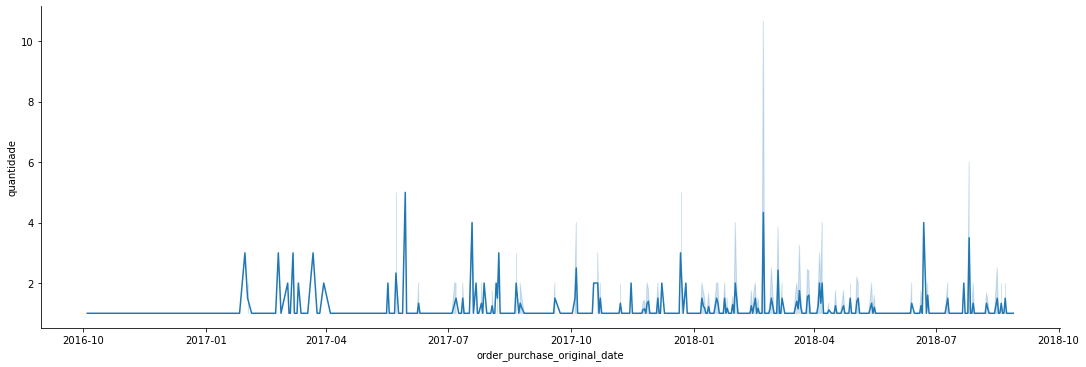

In [5]:
sns.relplot(
    data = joined_df[(joined_df["customer_city"] == "sao paulo") & (joined_df["product_category_name"] == "informatica_acessorios")],
    x = "order_purchase_original_date",
    y = "quantidade",
    kind = "line",
    aspect=3
) 

# Preparação dos dados

* **Filtragem dos registros**
  - Remoção de datas inconsistentes ou problemáticas
  - Seleção apenas dos produtos e cidades relevantes para análise

* **Criação de novas variáveis**
  - Horário do dia em que foi realizado cada pedido
  - Informações temporais complementares (dia da semana, mês etc.)
  - Identificação de feriados nacionais
  - Contagem de clientes novos por produto
  
* **Validação de completude**
  - Verificação e garantia de que não há datas com informações faltantes

* **Consolidação semanal**
  - Agregação dos valores de produtos em nível nacional
  - Transformação dos registros individuais em volumes semanais totais

In [6]:
def add_temporal_features(df, date_col):
    
    df["year"] = df[date_col].dt.year
    df["month"] = df[date_col].dt.month
    df["day_of_month"] = df[date_col].dt.day
    df["weekday"] = df[date_col].dt.day_name()
    
    return df

def add_holidays(df, cal):
    
    df = (
        df
        .merge(
            pd.concat(
                [pd.DataFrame(cal.holidays(2017), columns=['order_purchase_date', 'holiday']),
                 pd.DataFrame(cal.holidays(2018), columns=['order_purchase_date', 'holiday'])]
            ).astype(dtype={'order_purchase_date': "datetime64[ns]"})
            , how= "left"
        )
        .fillna({"holiday": "missing"})
    )
    df["flag_holiday"] = (df["holiday"] != "missing").astype(int)
    
    return df

def detect_new_clients(df, key_col_list):
    
    df["flag_new_client"] = df.groupby(key_col_list).cumcount() + 1
    df["flag_new_client"] = (df["flag_new_client"] == 1).astype(int)
    
    return df

def aggregate_cols_by_dates(df, key_cols_list):
    
    df = df.copy()
    df = (
        df
        .groupby(key_cols_list)
        .agg({
            "year": "min",
            "month": "min",
            "day_of_month": "max",
            "flag_holiday": "max", 
            "flag_approved_order": "mean",
            "flag_new_client": "mean",
            "daytime_in_minutes": ["mean", "median", "min", "max"],
            "quantidade": ["sum", "mean", "median", "min", "max"],
            "valor_total": ["sum", "mean", "median", "min", "max"],
            "frete_total": ["mean", "median", "min", "max"],
            "product_weight_g": ["mean", "median"]
        })
    )
    
    df.columns = df.columns.droplevel(1) + "_" + df.columns.droplevel(0)
    df = df.reset_index()
    
    return df

def filter_products_and_cities(df, prod_list, cities_list):
    
    return (
        df[(df["product_category_name"].isin(prod_list)) & (df["customer_city"].isin(cities_list))]
    )

def avoid_gap_dates(df, date_col, key_cols_list):
    
    start_date = df[date_col].min()
    final_date = df[date_col].max()
    print(final_date - start_date)
    
    dates_df = pd.DataFrame({
        date_col :pd.date_range(start=start_date, end=final_date, freq='D')
    })
    
    dates_df = dates_df.merge(df[key_cols_list].drop_duplicates(), how='cross')
    
    return (
        df
        .merge(dates_df, how="right")
        .fillna(value={"quantidade_sum": 0, "quantidade_mean": 0, "quantidade_median": 0, "quantidade_min": 0,
                       "quantidade_max": 0, "valor_total_sum": 0, "valor_total_mean": 0, "valor_total_median": 0,
                       "valor_total_min": 0, "valor_total_max": 0})
    )

In [8]:
cal = Brazil()

prod_list = ["cama_mesa_banho", "beleza_saude", "esporte_lazer", "informatica_acessorios", "moveis_decoracao"]
cities_list = ["sao paulo"]

joined_df = (
    joined_df[(joined_df['order_purchase_month'] >= pd.to_datetime("2017-01-01")) &
             (joined_df['order_purchase_month'] <= pd.to_datetime("2018-08-01"))]
)

joined_df["flag_approved_order"] = (~joined_df["order_status"].isin(['unavailable', 'canceled'])).astype(int)
joined_df["daytime_in_minutes"] = pd.to_datetime(joined_df['order_purchase_timestamp']).dt.hour*60 + pd.to_datetime(joined_df['order_purchase_timestamp']).dt.minute

joined_df = joined_df.sort_values("order_purchase_original_date")
joined_df = add_temporal_features(joined_df, date_col="order_purchase_original_date")
joined_df = add_holidays(joined_df, cal)
joined_df = detect_new_clients(joined_df, ["customer_id", 'product_category_name', "customer_state", 'customer_city'])
national_df = aggregate_cols_by_dates(joined_df, ['order_purchase_date', 'product_category_name'])

joined_df = filter_products_and_cities(joined_df, prod_list=prod_list, cities_list=cities_list)
joined_df = avoid_gap_dates(joined_df, "order_purchase_original_date", ['product_category_name', "customer_state", 'customer_city'])
final_df = aggregate_cols_by_dates(joined_df, ['order_purchase_date', 'product_category_name', "customer_state", 'customer_city'])

599 days 00:00:00


In [9]:
final_df.shape

(426, 30)

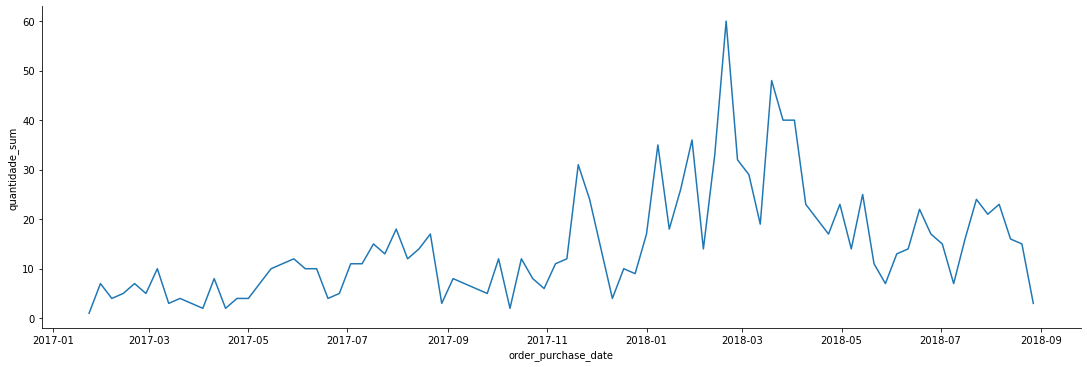

In [10]:
sns.relplot(
    data = final_df[(final_df["customer_city"] == "sao paulo") & (final_df["product_category_name"] == "informatica_acessorios")],
    x = "order_purchase_date",
    y = "quantidade_sum",
    kind = "line",
    aspect=3
)
# De fato, agregar pelas semanas auxiliou a suavizar a série temporal.

# Feature Engineering

As principais variáveis criadas nesta etapa incluem:  
- **Valores históricos recentes** (últimas 4 semanas)  
- **Média acumulada** (até a data atual) das métricas-chave  
- **Diferença percentual** entre o valor atual e a média histórica  

Essas features capturam tendências e anomalias temporais para melhorar a modelagem. 

In [11]:
def add_tendency_features(df, feat_list, key_col_list):
    
    for col in feat_list:
        
        df[f"{col}_lag"] = df.groupby(key_col_list)[col].shift(1)
        df[f"{col}_lag2"] = df.groupby(key_col_list)[col].shift(2)
        df[f"{col}_lag3"] = df.groupby(key_col_list)[col].shift(3)
        df[f"{col}_lag4"] = df.groupby(key_col_list)[col].shift(4)
        df[f"{col}_lag12"] = df.groupby(key_col_list)[col].shift(12)
        
        df[f"{col}_historical_mean"] = df.groupby(key_col_list)[col].cumsum()
        df[f"{col}_historical_mean"] = df[f"{col}_historical_mean"]/ (df.groupby(key_col_list).cumcount() + 1)
        df[f"{col}_historical_diff"] = (df[col] - df[f"{col}_historical_mean"])/df[f"{col}_historical_mean"]
        
    return df

In [12]:
feat_list = [
    "flag_approved_order_mean",
    "daytime_in_minutes_mean",
    'quantidade_mean',
    'quantidade_sum',
    'valor_total_sum',
    'frete_total_mean',
    'product_weight_g_mean',
    "flag_approved_order_mean",
    "flag_approved_order_mean_national",
    "flag_new_client_mean",
    "flag_new_client_mean_national",
    "daytime_in_minutes_mean_national",
    'quantidade_mean_national',
    'frete_total_mean_national',
    'product_weight_g_mean_national'
]

final_df = final_df.sort_values("order_purchase_date")
final_df = (
    final_df
    .merge(
        national_df,
        how="left", on=['order_purchase_date', 'product_category_name'],
        suffixes=('', '_national')
    )
)
final_df = add_tendency_features(final_df, feat_list, ['product_category_name', 'customer_city'])

# Criação do target - 7 dias

**Definição do Target** - Queremos prever:  
- O **volume de vendas** de cada produto  
- Para a **semana seguinte** à data de referência  

Como cada registro representa uma semana, o target é obtido pelo valor do registro posterior na série temporal. 

In [13]:
def add_target_by_product(df, target_col, horizon):
    
    df[f"target_{horizon}_semana"] = (
        df
        .groupby(['product_category_name', 'customer_city'])[target_col]
        .shift(-horizon)
    )
        
    return df

target_col = "quantidade_sum"
final_df = add_target_by_product(final_df, target_col, horizon=1)

In [25]:
final_df[final_df["product_category_name"] == "cama_mesa_banho"][['order_purchase_date', "quantidade_sum", "target_1_semana"]]

,order_purchase_date,quantidade_sum,target_1_semana
4,2017-01-16,200.00%,100.00%
11,2017-01-23,100.00%,500.00%
13,2017-01-30,500.00%,500.00%
18,2017-02-06,500.00%,600.00%
25,2017-02-13,600.00%,300.00%
...,...,...,...
403,2018-07-30,4500.00%,4400.00%
408,2018-08-06,4400.00%,4300.00%
415,2018-08-13,4300.00%,3000.00%
418,2018-08-20,3000.00%,300.00%


# Separação do treino/teste

* **Dados de treinamento**  
  - Séries temporais contínuas da cidade de São Paulo  
  - Utilizadas para ajustar o modelo de previsão de demanda semanal  

* **Período de avaliação**  
  - Intervalo de 3 meses independente (maio a julho)  
  - Garantia de separação total entre os conjuntos de treino e teste  

**Objetivo**: Assegurar que a avaliação do modelo reflita desempenho real, sem vazamento de dados entre as fases de treinamento e teste.  

In [14]:
def split_x_y(df, target_col):
    return df.drop(target_col, axis=1), df[target_col]

final_target_col = "target_1_semana"
limit_date = pd.to_datetime("2018-05-01")

x_train, y_train = split_x_y(final_df[final_df["order_purchase_date"] < limit_date], final_target_col)
x_val, y_val = split_x_y(final_df[final_df["order_purchase_date"] >= limit_date + timedelta(days=7)], final_target_col)

# Modelagem

Para a etapa preditiva, implementei três abordagens:

1. **Baseline Simples** (`latest_value_forecast`)
   - Repete o último valor observado como previsão

2. **Média Móvel** (`moving_average_forecast`)
   - Calcula a média dos últimos 3 períodos (janela ajustável)

3. **Modelo Avançado** (`catboost_forecast`)
   - Utiliza CatBoost, selecionado por sua capacidade de:
     - Lidar nativamente com variáveis categóricas
     - Bom desempenho em conjuntos de dados de tamanho pequeno
     - Tratar adequadamente padrões temporais

A comparação entre esses modelos permite avaliar o ganho real da abordagem mais sofisticada em relação às linhas de base mais simples.

In [17]:
def latest_value_forecast(df, group_col, value_col, date_col, days_to_predict):
    """
    Forecast by replicating the last value for each group
    Returns DataFrame with forecast dates and group values
    """
    
    df = df.copy()
    df[date_col] = df[date_col] + pd.to_timedelta(days_to_predict, unit='D')
    df["forecast"] = df[value_col]
    df["method"] = "latest_value_forecast"
    
    return df[[date_col, *group_col, value_col, "forecast", "method"]]

def moving_average_forecast(df, group_col, value_col, date_col, days_to_predict, window):
    """
    Forecast using moving average for each group
    Returns DataFrame with forecast dates and group values
    """
    
    df = df.copy()
    df[date_col] = df[date_col] + pd.to_timedelta(days_to_predict, unit='D')
    for i in range(window):
        df[f"lag{i}"] = df.groupby(group_col)[value_col].shift(i)

    lags = [f"lag{i}" for i in range(window)]
    df["forecast"] = df[lags].mean(axis=1)
    df["method"] = "ma_forecast"
    
    return df[[date_col, *group_col, value_col, "forecast", "method"]]

def catboost_model(x_train, y_train, x_val):
    
    cat_cols = list(x_train.select_dtypes("object").columns)
    model = CatBoostRegressor(
        random_seed=56,
        cat_features=cat_cols,
        verbose=0
    )
    
    return model.fit(x_train.drop("order_purchase_date", axis=1), y_train)

def catboost_forecast(model, x_val, group_col, days_to_predict):
    
    df = x_val[["order_purchase_date", *group_col]]
    df[date_col] = df[date_col] + pd.to_timedelta(days_to_predict, unit='D')
    df["forecast"] = model.predict(x_val.drop("order_purchase_date", axis=1)).round()
    df["method"] = "catboost"
    
    return df

In [18]:
group_col=['product_category_name', 'customer_city']
date_col="order_purchase_date"
days=7
window=3

df_val = x_val[["order_purchase_date", *group_col]].copy()
df_val[date_col] = df_val[date_col] + pd.to_timedelta(days, unit='D')
df_val["forecast"] = y_val
df_val["method"] = "actual_value"

cat_model = catboost_model(x_train, y_train, x_val)

forecast_df = pd.concat([
    latest_value_forecast(x_val, group_col, target_col, date_col, days),
    moving_average_forecast(x_val, group_col, target_col, date_col, days, window),
    catboost_forecast(cat_model, x_val, group_col, days),
    df_val
]).drop(target_col, axis=1)

<ipython-input-17-25f287fd9413>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[date_col] = df[date_col] + pd.to_timedelta(days_to_predict, unit='D')
<ipython-input-17-25f287fd9413>:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["forecast"] = model.predict(x_val.drop("order_purchase_date", axis=1)).round()
<ipython-input-17-25f287fd9413>:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the 

# Avaliação dos modelos

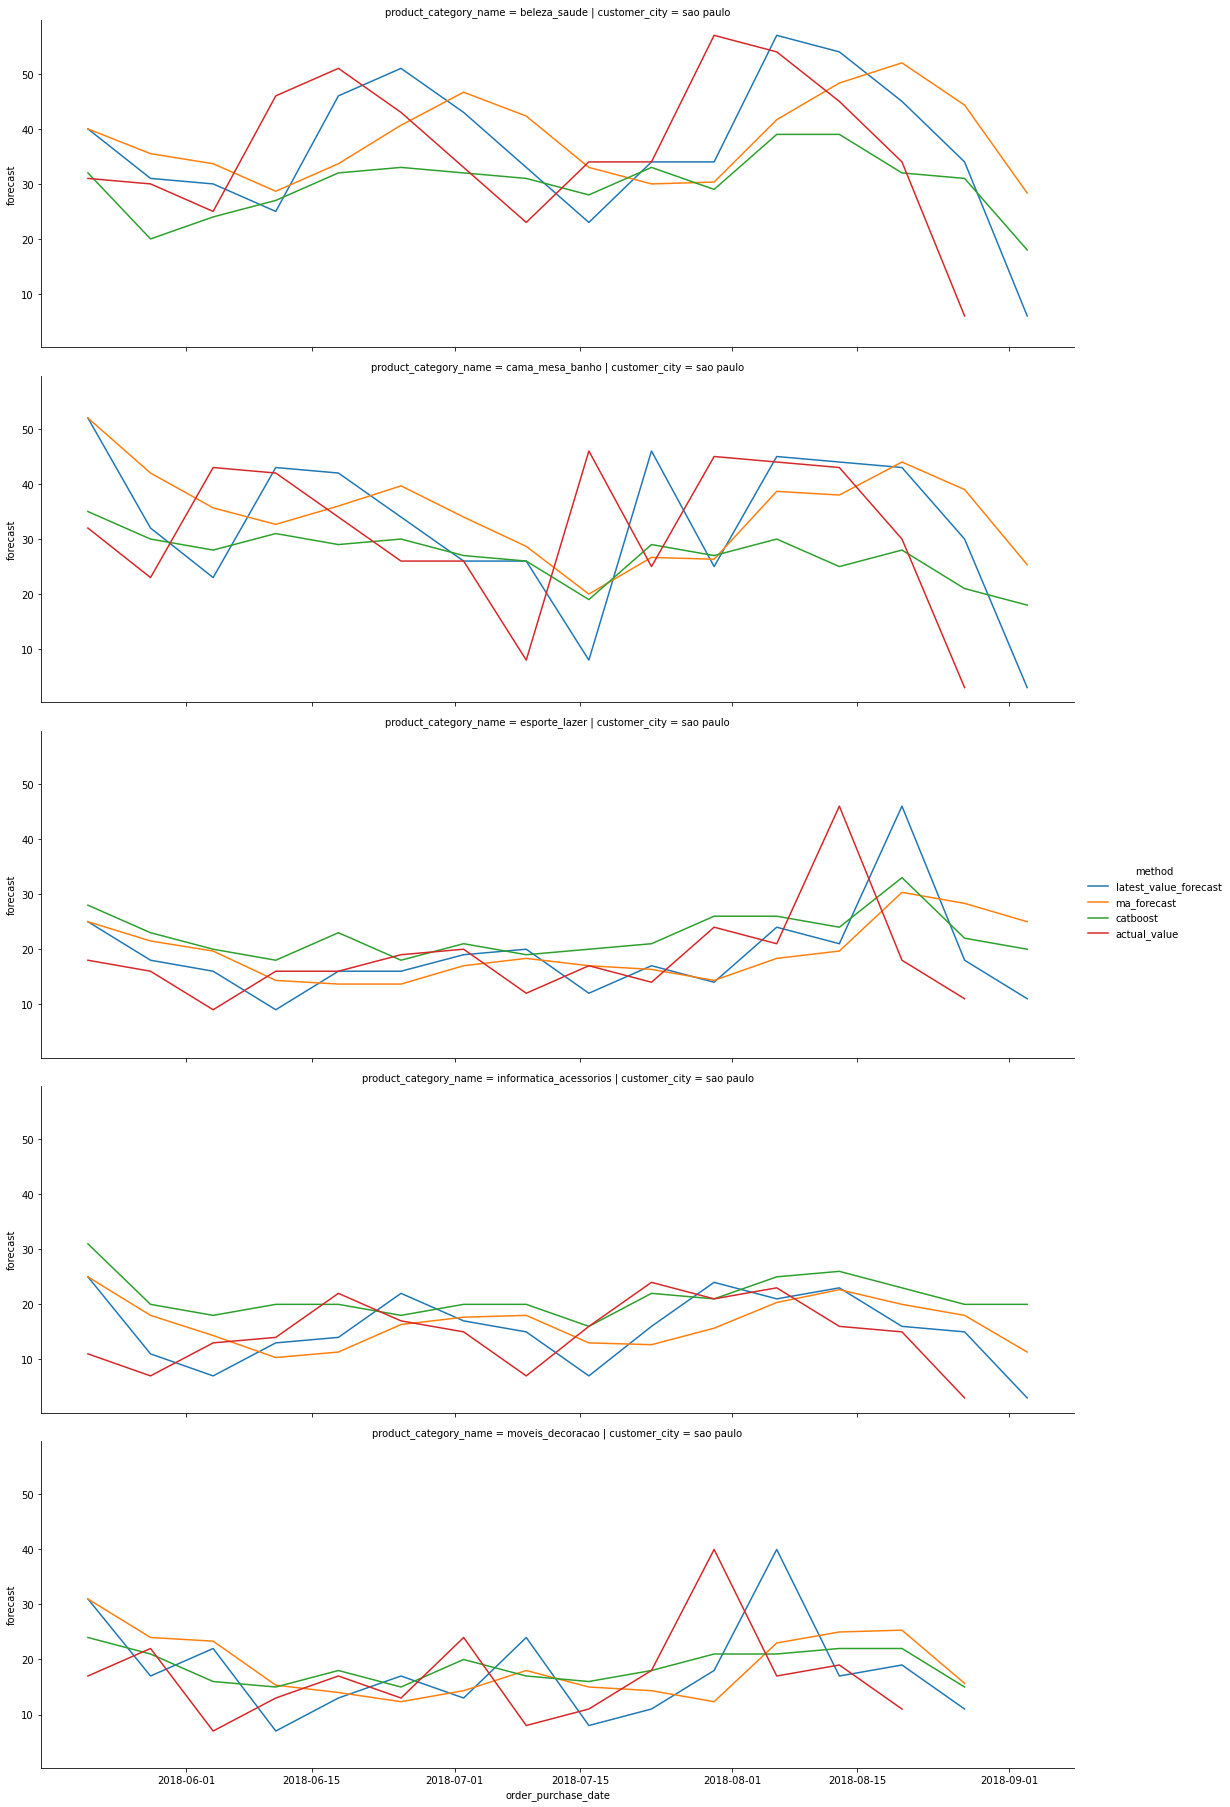

In [19]:
sns.relplot(
    data = forecast_df,
    x = "order_purchase_date",
    y = "forecast",
    kind = "line",
    hue = "method",
    col = "customer_city",
    row = "product_category_name",
    aspect=3
) 
plt.show()

**Interpretação das Métricas e Resultados**

* **RMSE (Root Mean Squared Error)**
  - Penaliza mais fortemente erros grandes em valores absolutos
  - Exemplo: Um RMSE de 50 significa que, em média, as previsões erram por ±50 unidades

* **MAPE (Mean Absolute Percentage Error)**
  - O valor mais comum foi 40%, indicando que:
    - Para a maioria dos produtos, as previsões tiveram um erro médio de 40% em relação ao valor real
    - Um MAPE de 40% é considerado moderado em previsão de demanda - aceitável para produtos com alta variabilidade;

**Desempenho Relativo**:
1. O CatBoost superou os baselines em ambas métricas na maioria dos casos;
2. Limitação característica:Modelos baseados em árvores (como CatBoost) não extrapolam bem valores fora do intervalo observado no treino, consequentemente, tendem a subestimar picos de demanda inéditos

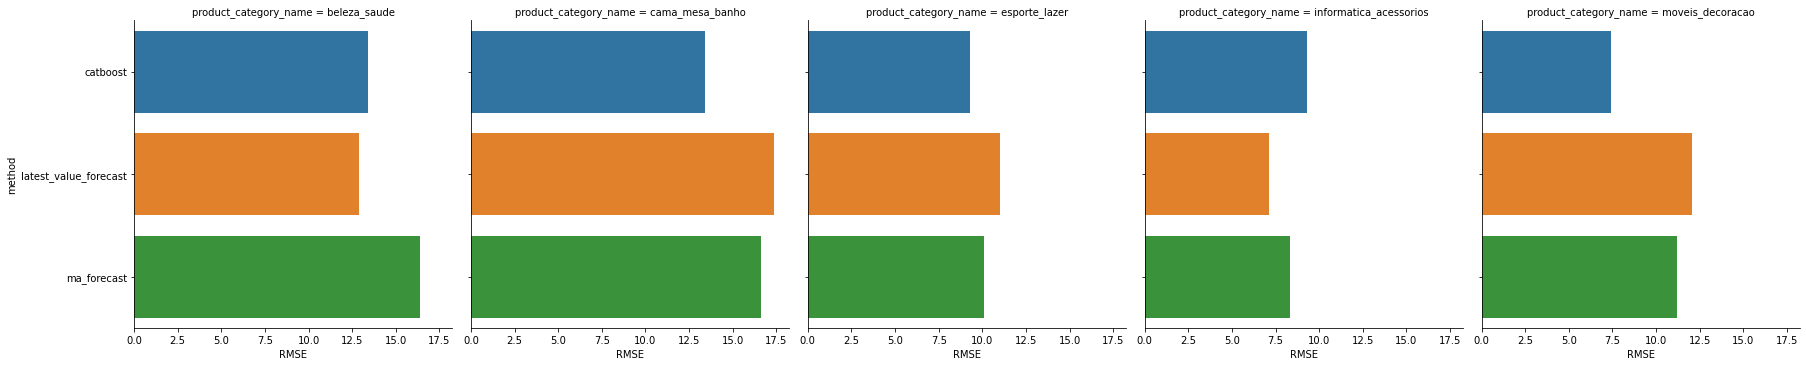

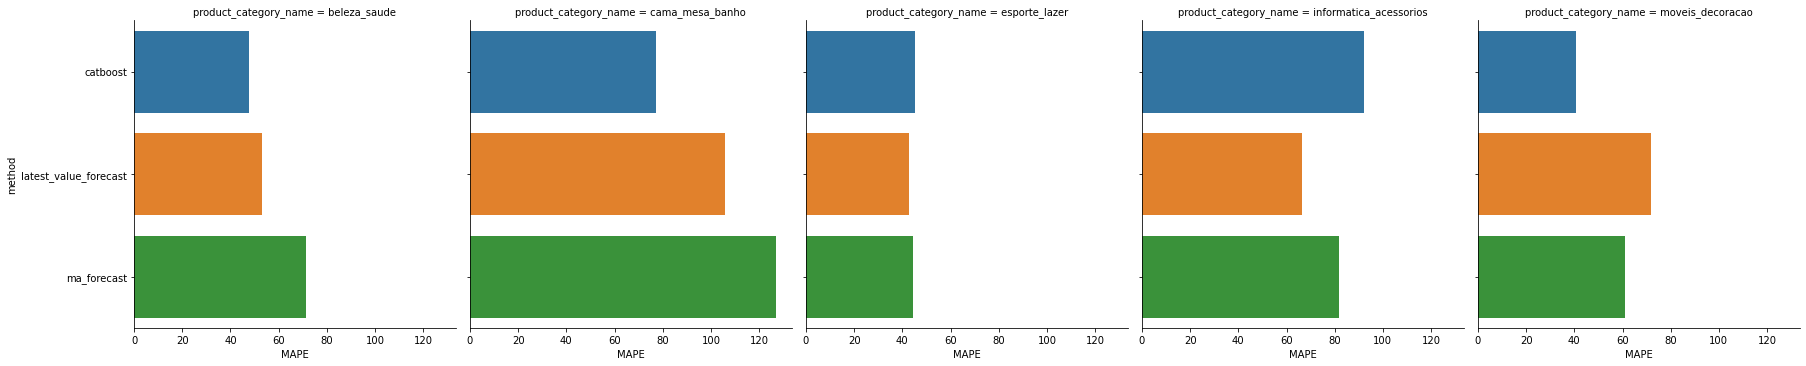

In [20]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def calculate_metrics_by_group(df, group_cols, date_col, y_true, y_pred):
    """
    Calcula métricas de regressão agrupadas por categorias
    
    Parâmetros:
        df: DataFrame com dados
        group_cols: Lista de colunas para agrupamento (ex: ['cidade', 'produto'])
        date_col: Coluna de data para agregação temporal
        y_true: Nome da coluna com valores reais
        y_pred: Nome da coluna com previsões
    """
    results = df.groupby(group_cols).apply(
        lambda x: pd.Series({
            'RMSE': np.sqrt(mean_squared_error(x[y_true], x[y_pred])),
            'MAPE': np.mean(np.abs((x[y_true] - x[y_pred]) / x[y_true])) * 100,
            'Count': len(x)
        })
    ).reset_index()
    
    return results

df_val = df_val.rename(columns={"forecast": "actual_value"})
df_val.loc[:, 'actual_value'] = df_val['actual_value'].replace(0, 0.1)
forecast_df = forecast_df[forecast_df["method"] != "actual_value"].merge(df_val.drop("method", axis=1)).dropna()

metrics_by_group = calculate_metrics_by_group(
    df=forecast_df,
    group_cols=['product_category_name', 'customer_city', "method"],
    date_col='order_purchase_date',
    y_true='actual_value',
    y_pred='forecast'
)


for metric in ["RMSE", "MAPE"]:
    sns.catplot(
        data = metrics_by_group,
        x = metric,
        y = "method",
        kind = "bar",
        col = "product_category_name"
    )
    plt.show()

**Monitoramento Temporal do Desempenho**  

Para modelos de previsão temporal, é essencial avaliar a degradação das métricas (RMSE/MAPE) ao longo do tempo, pois padrões de demanda podem mudar (sazonalidade, comportamento do consumidor). Em alguns casos dá para observar pior desempenho em datas específicas, indicando demanda atípica e também pior desempenho justo nas últimas semanas. 

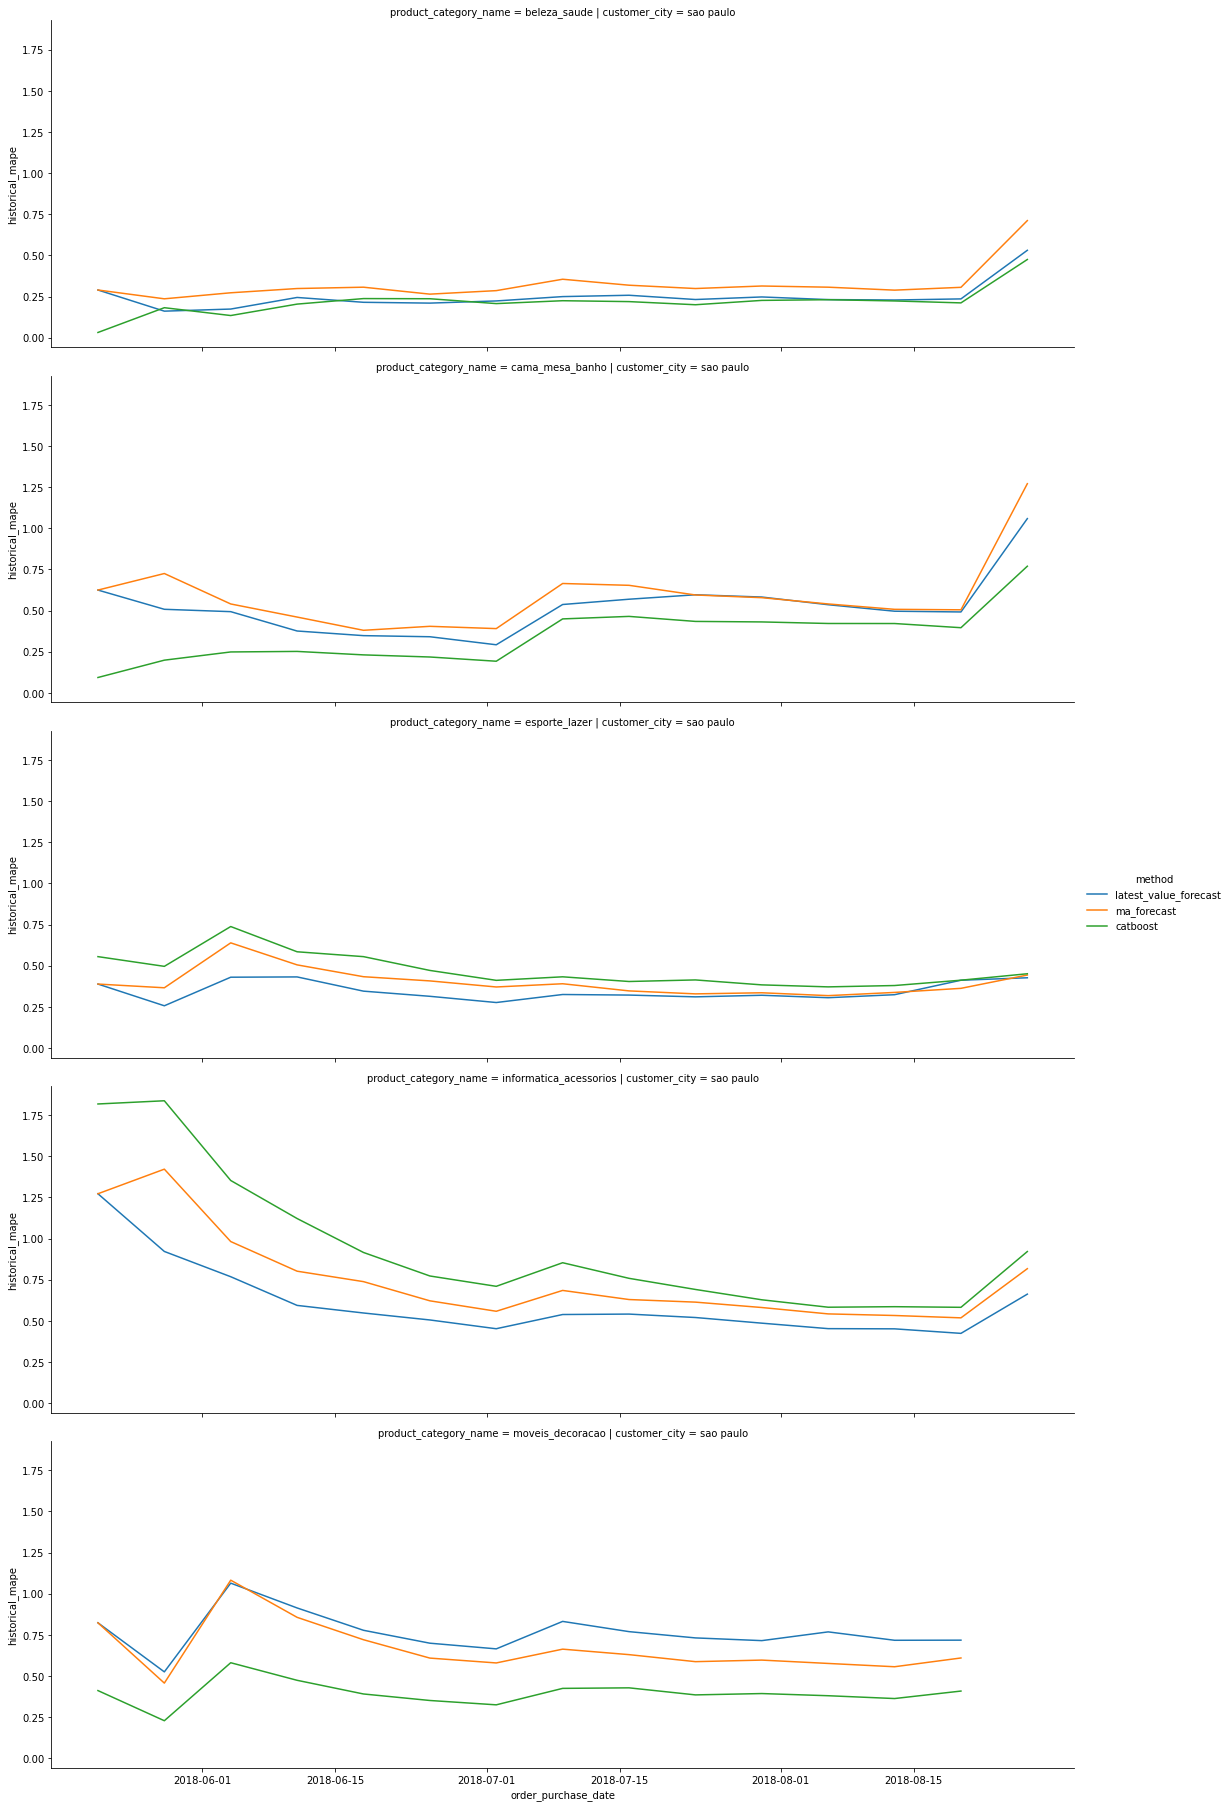

In [21]:
forecast = forecast_df.copy()
forecast["mape"] = np.abs((forecast_df['actual_value'] - forecast_df['forecast']) / forecast_df['actual_value'])
forecast[f"historical_mape"] = forecast.groupby(['product_category_name', 'customer_city', "method"])["mape"].cumsum()
forecast[f"historical_mape"] = forecast[f"historical_mape"]/ (forecast.groupby(['product_category_name', 'customer_city', "method"]).cumcount() + 1)

sns.relplot(
    data = forecast,
    x = "order_purchase_date",
    y = "historical_mape",
    kind = "line",
    hue = "method",
    col = "customer_city",
    row = "product_category_name",
    aspect=3
) 
plt.show()

**Análise de Feature Importance**  

Para compreender o comportamento do modelo, avaliamos a **importância das variáveis**, calculada com base no:  

- **Ganho médio** proporcionado por cada feature nas divisões das árvores  
- **Contribuição relativa** para as previsões  

**Principais insights**:  
- O comportamento nacional dos produtos influencia bastante nas previsões

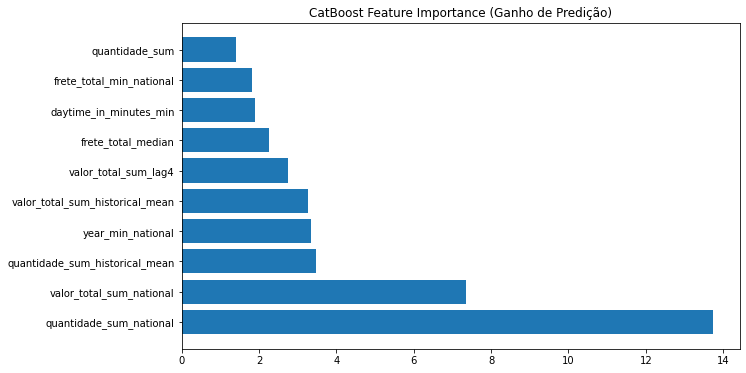

In [22]:
feature_importance = cat_model.get_feature_importance()

importance_df = pd.DataFrame({
    'Feature': x_train.drop("order_purchase_date", axis=1).columns,
    'Importance': feature_importance
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10))
plt.title('CatBoost Feature Importance (Ganho de Predição)')
plt.show()